In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import os
import tqdm

import seaborn as sns
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.utils import make_grid
from attrdict import AttrDict
import torch
import yaml
from sklearn.model_selection import StratifiedKFold
import copy
import pickle
# from tqdm import tqdm_notebook

# additional lightning 

import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningDataModule, LightningModule


from PIL import Image

import glob

# pytorch
import torch
from torch import nn
import torch.nn.functional as F
from timm import create_model

import sys
sys.path.append("../")
from pawnet.utility import *

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import torch
import torch.nn.functional as F
import pandas as pd
import torchvision
from torchvision import models
import matplotlib.pyplot as plt


from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

from captum.attr import Saliency

from captum.attr import LayerGradCam
import skimage.transform

In [21]:
config_path = "../config/config.yaml"


base_config_manager = BaseConfigLoader(config_path)
file_path = base_config_manager.load_config().filepath.gcs

train_df = pd.read_csv(os.path.join(file_path,"train.csv"))

In [48]:
n=1
imgs = pd.concat([train_df[train_df.Pawpularity < 30].sample(n),
                 train_df[(train_df.Pawpularity > 30) & (train_df.Pawpularity < 50)].sample(n),
                 train_df[train_df.Pawpularity > 50].sample(n)])

In [49]:
test_transformation = T.Compose([
                T.Resize([224,224]),# imgnet needs at least 224
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] ), # imgnet requirements 
                ]
            )
criterion = torch.nn.BCEWithLogitsLoss()

In [50]:
# img_paths = glob.glob(file_path+'train/*')
# img_paths2 =  [x for x in img_paths if '-' not in x]

/opt/conda/lib/python3.7/site-packages/captum/_utils/gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


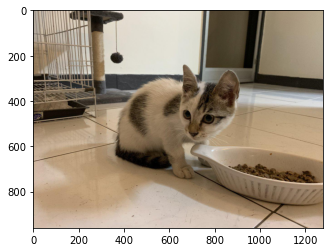

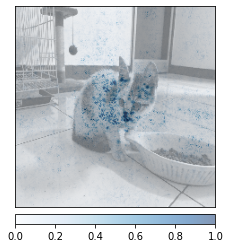

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


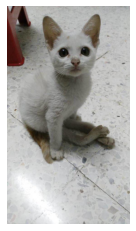

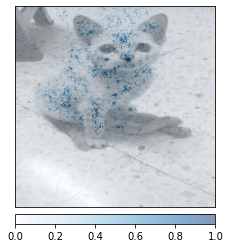

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


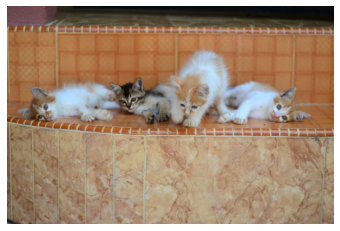

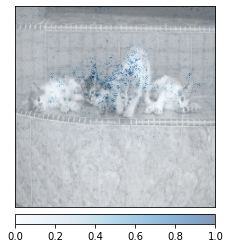

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


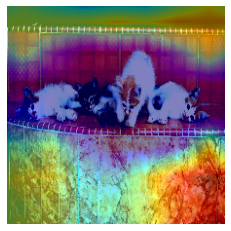

In [51]:
SHOW = True
SAVE = False

resnet_dir = 'resnet/default/'
model_config = base_config_manager.load_config().model.resnet34
model = pawNetBasic.load_from_checkpoint(checkpoint_path=resnet_dir+'version_0/checkpoints/best_loss.ckpt',criterion=criterion,model_config=model_config)
target_layer = [model.pretrained.layer4[2].conv2]

test_img = file_path+"train/0007de18844b0dbbb5e1f607da0606e0.jpg"

model_nm = 'resnet'
for ix, row in imgs.iterrows():
    #print(model_nm, target_layer)
    model = model.to("cuda")
    model.eval()

    #img_path = test_img
    img_path = os.path.join(file_path,'train', row.Id+'.jpg')
    with open(img_path, 'rb') as f:
        img = Image.open(f)
        if SHOW:
            plt.imshow(img)
        img = (img).convert("RGB")
        img = T.ToTensor()(img)
        f.close()

    input = test_transformation(img)
    input = input.unsqueeze(0)

    # output = model(input.cuda())
    # output = F.softmax(output, dim=1)
    # prediction_score, pred_label_idx = torch.topk(output, 1)

    # pred_label_idx.squeeze_(), prediction_score.squeeze().item()
    # #predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    # #print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

    """saliency map"""
    saliency = Saliency(model)
    grads = saliency.attribute(input.cuda(), target=0)
    grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

    fig = plt.figure()
    ax=plt.subplot(1,1,1)
    viz.visualize_image_attr(grads, 
                                np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)), 
                                method="blended_heat_map", 
                                sign="absolute_value",\
                                show_colorbar=True,#,
                                #fig_size=(3,3),
                                plt_fig_axis=(fig, ax))
    img_out_path = 'visualizations/'+model_nm+'_sal_'+str(img_path.lower().split('/')[3])
    if SAVE:
        fig.savefig(img_out_path)
    plt.close(fig)

    """grad cam"""

    layer_gc = LayerGradCam(model, target_layer[0])

    # get for each class 
    attr_1 = layer_gc.attribute(input.cuda(), 0, relu_attributions=True)

    plt.imshow(np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)))
    plt.imshow(skimage.transform.resize(attr_1.detach().cpu().numpy()[0][0], (224,224)), alpha=0.5, cmap='jet')
    plt.axis("off")
    img_out_path = 'visualizations/'+model_nm+'_grad_'+str(img_path.lower().split('/')[3])
    if SAVE:
        plt.savefig(img_out_path)
    plt.close(fig)

will perform cutmix


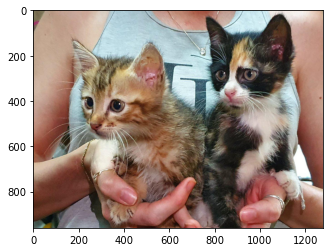

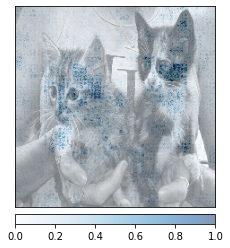

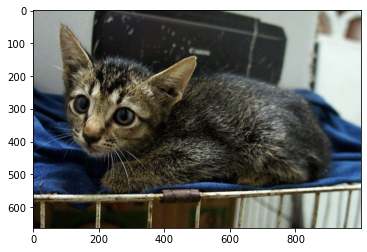

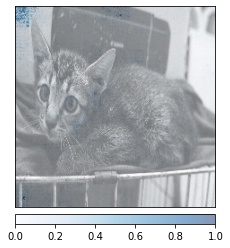

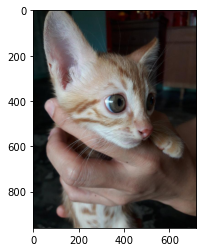

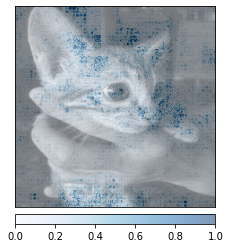

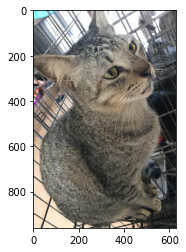

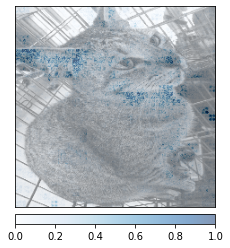

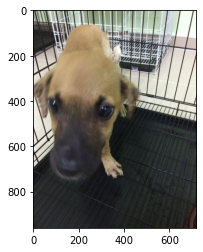

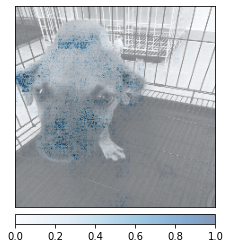

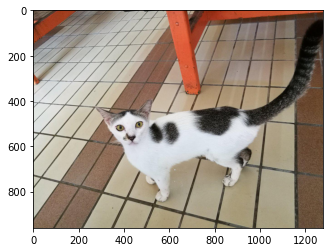

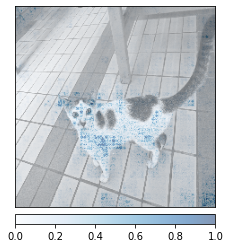

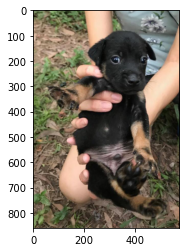

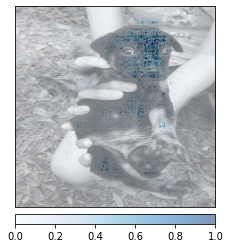

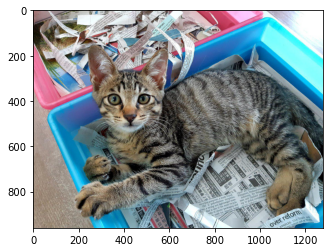

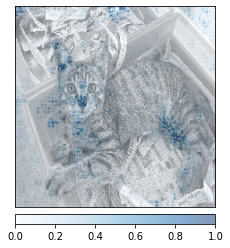

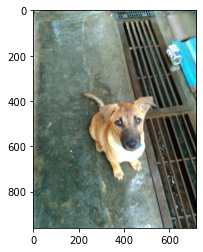

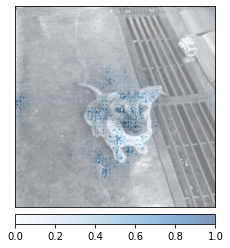

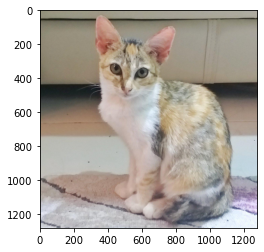

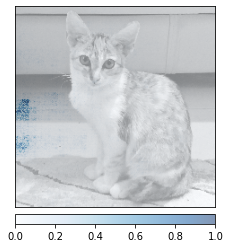

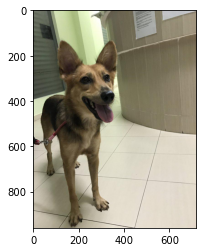

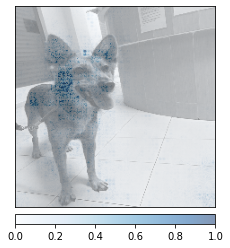

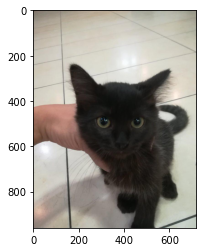

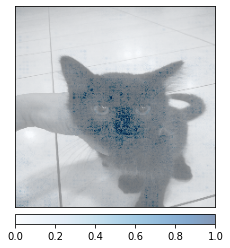

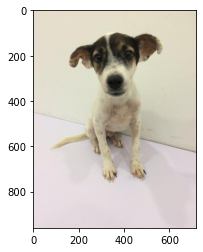

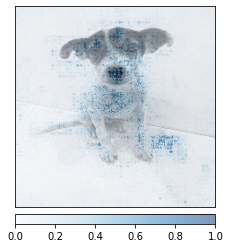

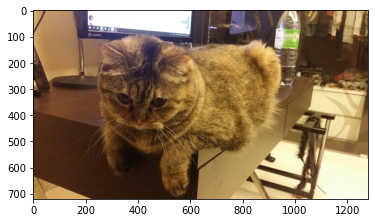

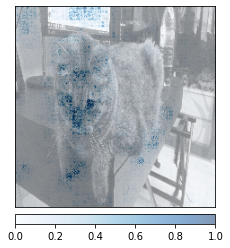

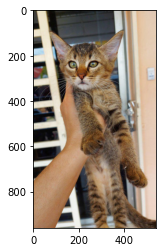

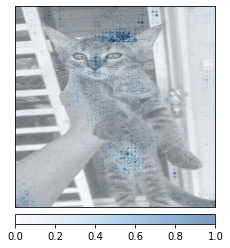

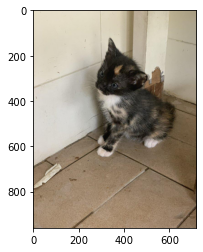

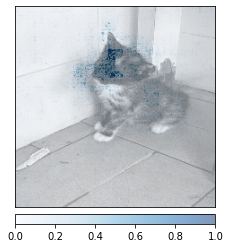

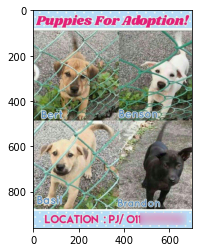

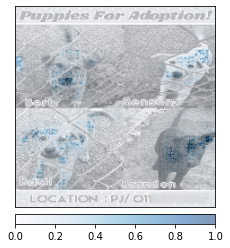

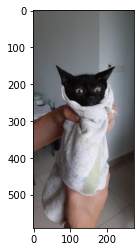

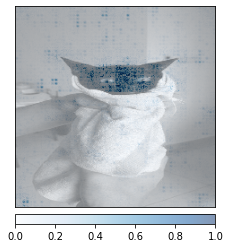

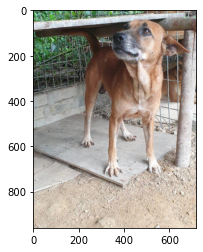

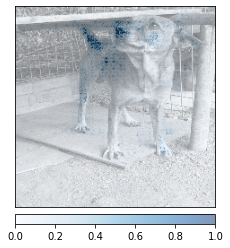

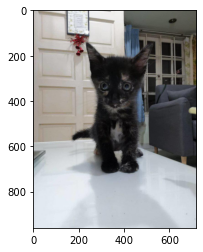

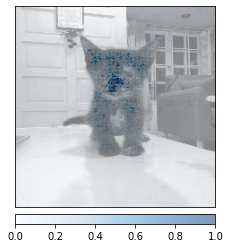

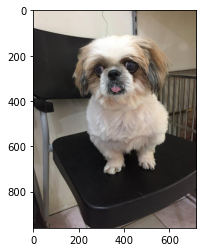

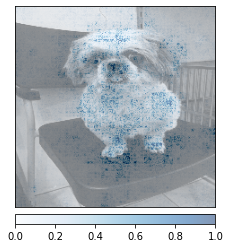

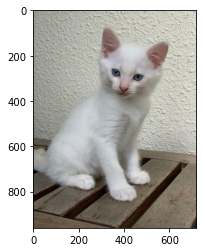

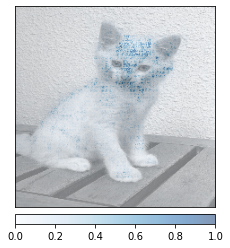

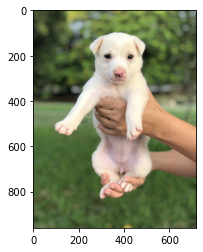

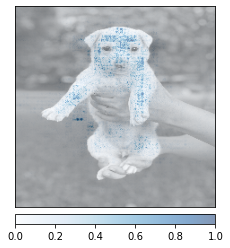

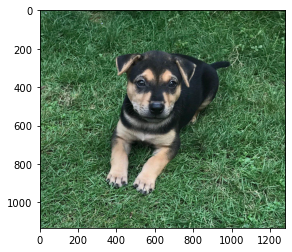

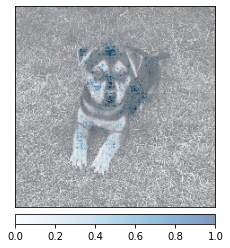

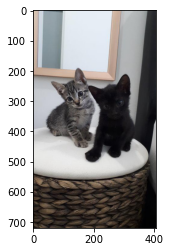

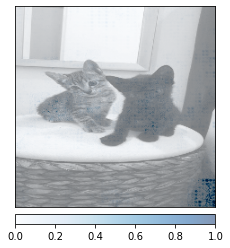

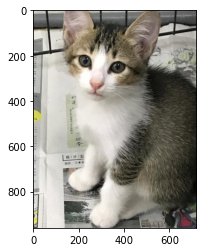

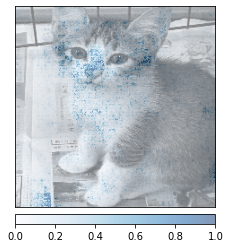

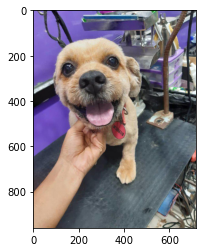

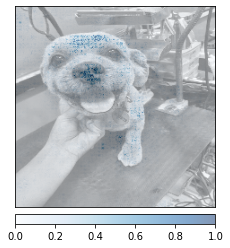

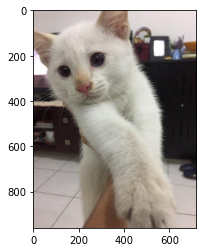

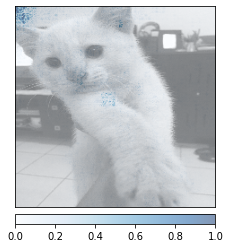

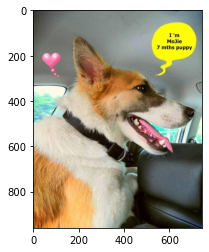

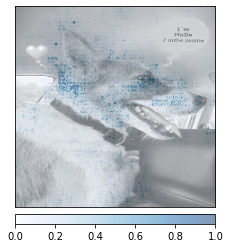

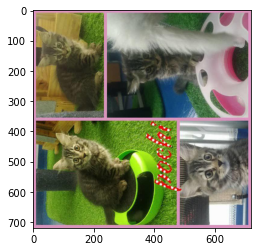

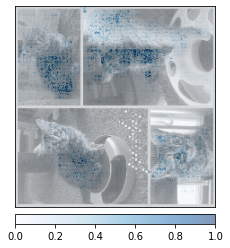

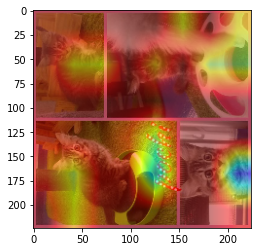

In [47]:
"""swin"""


swin_dir = 'pseudo/'
model_config = base_config_manager.load_config().model.swin_tiny4_w7_224_cut1
model = pawNetBasic.load_from_checkpoint(checkpoint_path=swin_dir+'version_0/checkpoints/best_loss.ckpt',criterion=criterion,model_config=model_config)
target_layer = [model.pretrained.layers[3].blocks[1].norm2]

# !pip install grad-cam
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2


def reshape_transform(tensor, height=6, width=8):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0), 
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

cam = GradCAMPlusPlus(model=model, 
                      target_layers=target_layer,
                      reshape_transform=reshape_transform)

model_nm = 'swin'

for ix, row in imgs.iterrows():
    model = model.to("cuda")
    model.eval()

    #img_path = test_img
    img_path = os.path.join(file_path,'train', row.Id+'.jpg')
    with open(img_path, 'rb') as f:
        img = Image.open(f)
        if SHOW:
            plt.imshow(img)
        img = (img).convert("RGB")
        img = T.ToTensor()(img)
        f.close()

    input = test_transformation(img)
    input = input.unsqueeze(0)

    # output = model(input.cuda())
    # output = F.softmax(output, dim=1)
    # prediction_score, pred_label_idx = torch.topk(output, 1)

    # pred_label_idx.squeeze_(), prediction_score.squeeze().item()
    # #predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    # #print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

    """saliency map"""
    saliency = Saliency(model)
    grads = saliency.attribute(input.cuda(), target=0)
    grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

    fig = plt.figure()
    ax=plt.subplot(1,1,1)
    viz.visualize_image_attr(grads, 
                                np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)), 
                                method="blended_heat_map", 
                                sign="absolute_value",\
                                show_colorbar=True,#,
                                #fig_size=(3,3),
                                plt_fig_axis=(fig, ax))
    img_out_path = 'visualizations/'+model_nm+'_sal_'+str(img_path.lower().split('/')[3])
    if SAVE:
        fig.savefig(img_out_path)
    plt.close(fig)

    """grad cam"""

    rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5], 
                                              std=[0.5, 0.5, 0.5]).cuda()
    grayscale_cam = cam(input_tensor=input_tensor,
                        target_category=0,
                        eigen_smooth=True,
                        aug_smooth=True)

    grayscale_cam = grayscale_cam[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam)
    plt.imshow(cam_image)

    img_out_path = 'visualizations/'+model_nm+'_grad_'+str(img_path.lower().split('/')[3])
    if SAVE:
        plt.savefig(img_out_path)
    plt.close(fig)


In [ ]:
# for name, layer in model.named_modules():
#     print(name)

In [77]:
# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from torchvision.models import resnet50

# target_layer = model.pretrained.layer4[-1]
# input_tensor = # Create an input tensor image for your model..
# # Note: input_tensor can be a batch tensor with several images!

# # Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=True)

# # If target_category is None, the highest scoring category
# # will be used for every image in the batch.
# # target_category can also be an integer, or a list of different integers
# # for every image in the batch.
# target_category = 281

# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(rgb_img, grayscale_cam)

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


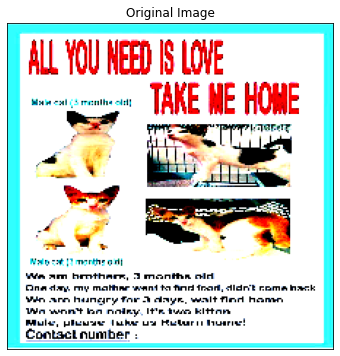

In [53]:
# _ = viz.visualize_image_attr(None, np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
#                       method="original_image", title="Original Image")

In [54]:
# train_df.iloc[0].Pawpularity

63

In [120]:
# !pip install captum 

# from captum.attr import IntegratedGradients
# from captum.attr import GradientShap
# from captum.attr import Saliency
# from captum.attr import NoiseTunnel
# from captum.attr import visualization as viz

# import torch
# import torch.nn.functional as F

# from PIL import Image

# import os
# import json
# import numpy as np
# from matplotlib.colors import LinearSegmentedColormap

# # Create IntegratedGradients object and get attributes
# integrated_gradients = IntegratedGradients(model)
# attributions_ig = integrated_gradients.attribute(input.cuda(), target=0, n_steps=200)

# # create custom colormap for visualizing the result
# default_cmap = LinearSegmentedColormap.from_list('custom blue', 
#                                                  [(0, '#ffffff'),
#                                                   (0.25, '#000000'),
#                                                   (1, '#000000')], N=256)


# # visualize the results using the visualize_image_attr helper method
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
#                              np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                              methods=["original_image", "heat_map"],
#                              signs=['all', 'positive'],
#                              cmap=default_cmap,
#                              show_colorbar=True)

RuntimeError: shape '[200, 6, 8, 7]' is invalid for input of size 5007800